Dieses Notebook führt eine feature selection mit permutation importance durch.

In [2]:
from utils.training import get_features_and_labels
from sklearn.ensemble import RandomForestClassifier
import joblib
from datetime import datetime

feature_file = 'features/features.hdf5'
data_split_file = 'data_split.yaml'
split_train = 'train'
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'


X_train, y_train = get_features_and_labels(feature_file, None, split_train, data_split_file)

clf = RandomForestClassifier(n_jobs=-1, max_depth=25, class_weight='balanced')
clf.fit(X_train, y_train)

joblib.dump(clf, model_save_path)


Extracting features and labels for sessions: 100%|██████████| 268/268 [00:06<00:00, 41.86it/s]


['./models/07-12-25 13-20-07.joblib']

In [ ]:
from sklearn.inspection import permutation_importance
from utils.training import get_features_and_labels
import joblib

feature_file = 'features/features.hdf5'
data_split_file = 'data_split.yaml'
split_val = 'val'
model_path = './models/07-12-25 13-20-07.joblib'
random_state = 42

X_val, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file)
clf = joblib.load(model_path)

importance = permutation_importance(clf, X_val, y_val, scoring='f1', n_jobs=-1, random_state=random_state)
joblib.dump(importance, 'output/exp_03_12_feature_importance.joblib')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 159.94it/s]


In [21]:

sorted(importance['importances_mean'])[-25:]

[np.float64(0.0020022628530367735),
 np.float64(0.002097541656806734),
 np.float64(0.0025410479884616865),
 np.float64(0.0027448947022151505),
 np.float64(0.0029477637153453085),
 np.float64(0.003021004241351699),
 np.float64(0.003103154284015064),
 np.float64(0.0031054521887663887),
 np.float64(0.003138235844485182),
 np.float64(0.0032650373183856773),
 np.float64(0.00377777075404957),
 np.float64(0.004808615164702745),
 np.float64(0.004871855205416708),
 np.float64(0.005334422964883156),
 np.float64(0.006020876762514171),
 np.float64(0.008046480329438666),
 np.float64(0.008518803336869541),
 np.float64(0.01283456722119023),
 np.float64(0.019262784801608545),
 np.float64(0.02032601034592498),
 np.float64(0.02335749328878145),
 np.float64(0.027953853214478297),
 np.float64(0.03131618417130459),
 np.float64(0.03422652270865247),
 np.float64(0.03633931894613847)]

Nun soll einmal ein Modell auf den 25 wichtigsten Features trainiert werden.

In [25]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import numpy as np
from utils.training import get_features_and_labels

feature_file = 'features/features.hdf5'
data_split_file = 'data_split.yaml'
split_train = 'train'
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'
top_n_features = 25
random_state = 42

importance_path = 'output/exp_03_12_feature_importance.joblib'

importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:25]

X_train, y_train = get_features_and_labels(feature_file, None, split_train, data_split_file)
X_train = X_train[:, top_n_features_idx]

clf = RandomForestClassifier(max_depth=25, class_weight='balanced', n_jobs=-1, random_state=random_state)
clf.fit(X_train, y_train)

joblib.dump(clf, model_save_path)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:07<00:00, 36.86it/s]


['./models/07-12-25 13-44-13.joblib']

In [26]:
import numpy as np
from utils.training import get_features_and_labels
import joblib
from sklearn.metrics import classification_report

feature_file = 'features/features.hdf5'
data_split_file = 'data_split.yaml'
split_val = 'val'
model_path = './models/07-12-25 13-44-13.joblib'
top_n_features = 25
random_state = 42

importance_path = 'output/exp_03_12_feature_importance.joblib'

importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:25]

X_val, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file)
X_val = X_val[:, top_n_features_idx]

clf = joblib.load(model_path)
y_pred = clf.predict(X_val)

print(f'Classification report on validation set:\n\n{classification_report(y_val, y_pred)}')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:02<00:00, 128.65it/s]


Classification report on validation set:

              precision    recall  f1-score   support

           0       0.92      0.89      0.91    971776
           1       0.57      0.66      0.61    210350

    accuracy                           0.85   1182126
   macro avg       0.75      0.78      0.76   1182126
weighted avg       0.86      0.85      0.85   1182126



In [27]:
import joblib
from utils.training import predict_random_forest
from utils.evaluation import get_iou_for_set
import numpy as np
import matplotlib.pyplot as plt

split_val = 'val'
feature_file = "./features/features.hdf5"
data_split_file = "./data_split.yaml"
features = None
model_path = './models/07-12-25 13-44-13.joblib'
top_n_features = 25
overlap_treshold_values = np.linspace(0, 1, num = 21)

importance_path = 'output/exp_03_12_feature_importance.joblib'

importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:25]

X_val, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file)
X_val = X_val[:, top_n_features_idx]

precision_values_val = []
recall_values_val = []
f1_values_val = []

clf = joblib.load(model_path)
y_pred_val = clf.predict(X_val)

for overlap_treshold in overlap_treshold_values:
    precision_val, recall_val, f1_val = get_iou_for_set(overlap_treshold, y_pred_val, data_split_file, split_val, feature_file)

    precision_values_val.append(precision_val)
    recall_values_val.append(recall_val)
    f1_values_val.append(f1_val)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 156.66it/s]


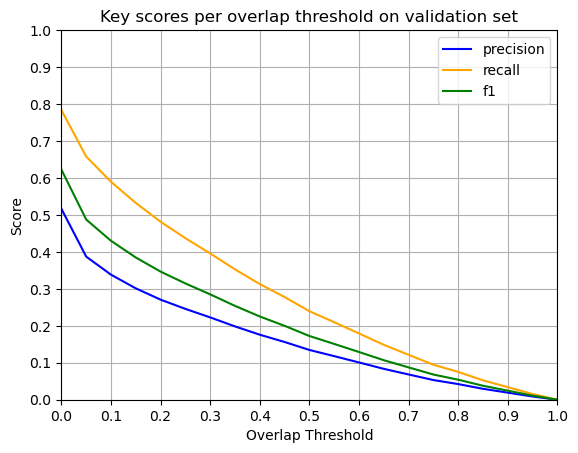

In [28]:
ticks = np.linspace(0, 1, num=11)

plt.xticks(ticks)
plt.yticks(ticks)

plt.plot(overlap_treshold_values, precision_values_val, label='precision', color='blue')
plt.plot(overlap_treshold_values, recall_values_val, label='recall', color='orange')
plt.plot(overlap_treshold_values, f1_values_val, label='f1', color='green')

plt.xlabel('Overlap Threshold')
plt.ylabel('Score')
plt.title('Key scores per overlap threshold on validation set')
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('output/exp_03_12_iou_f1_val_feature_importance.pdf', bbox_inches='tight')
plt.show()